In [27]:
import os
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.ticker as mticker
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [28]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'

In [29]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5',engine='h5netcdf') as ds:
    lev = ds['lev'].load()

def _seed_mean(da):
    return da.mean('member') if 'member' in da.dims else da

def load_kernel_weights_across_seeds(model_name):
    pattern = f'{model_name}_seed*_{SPLIT}_weights.nc'
    files = sorted(glob.glob(os.path.join(WEIGHTSDIR, pattern)))
    if not files:
        return None
    k_list, k1_list, k2_list = [], [], []
    for fp in files:
        with xr.open_dataset(fp, engine='h5netcdf') as ds:
            if ('k1' in ds) and ('k2' in ds):
                k1_list.append(_seed_mean(ds['k1'].load()))
                k2_list.append(_seed_mean(ds['k2'].load()))
            else:
                var = 'k' if 'k' in ds else 'weights'
                k_list.append(_seed_mean(ds[var].load()))
    if k1_list: 
        k1 = xr.concat(k1_list, dim='seed')
        k2 = xr.concat(k2_list, dim='seed')
        return {
            'kind': 'mixture',
            'n': k1.sizes['seed'],
            'mean1': k1.mean('seed'),
            'mean2': k2.mean('seed'),
            'std1':  k1.std('seed') if k1.sizes['seed'] > 1 else None,
            'std2':  k2.std('seed') if k2.sizes['seed'] > 1 else None,}
    else:         
        k = xr.concat(k_list, dim='seed')
        return {
            'kind': 'single',
            'n': k.sizes['seed'],
            'mean': k.mean('seed'),
            'std':  k.std('seed') if k.sizes['seed'] > 1 else None}

In [30]:
results = {}
for m in MODELS:
    name = m['name']
    if 'kernel' not in name:
        continue
    out = load_kernel_weights_across_seeds(name)
    if out is None:
        continue
    results[name] = dict(description=m['description'], **out)
    print(f'{name}: n={out["n"]}')

print(f'Found {len(results)} kernel models with saved weights')

kernel_gaussian_vertical: n=3
kernel_exponential_vertical: n=3
kernel_tophat_vertical: n=3
Found 3 kernel models with saved weights


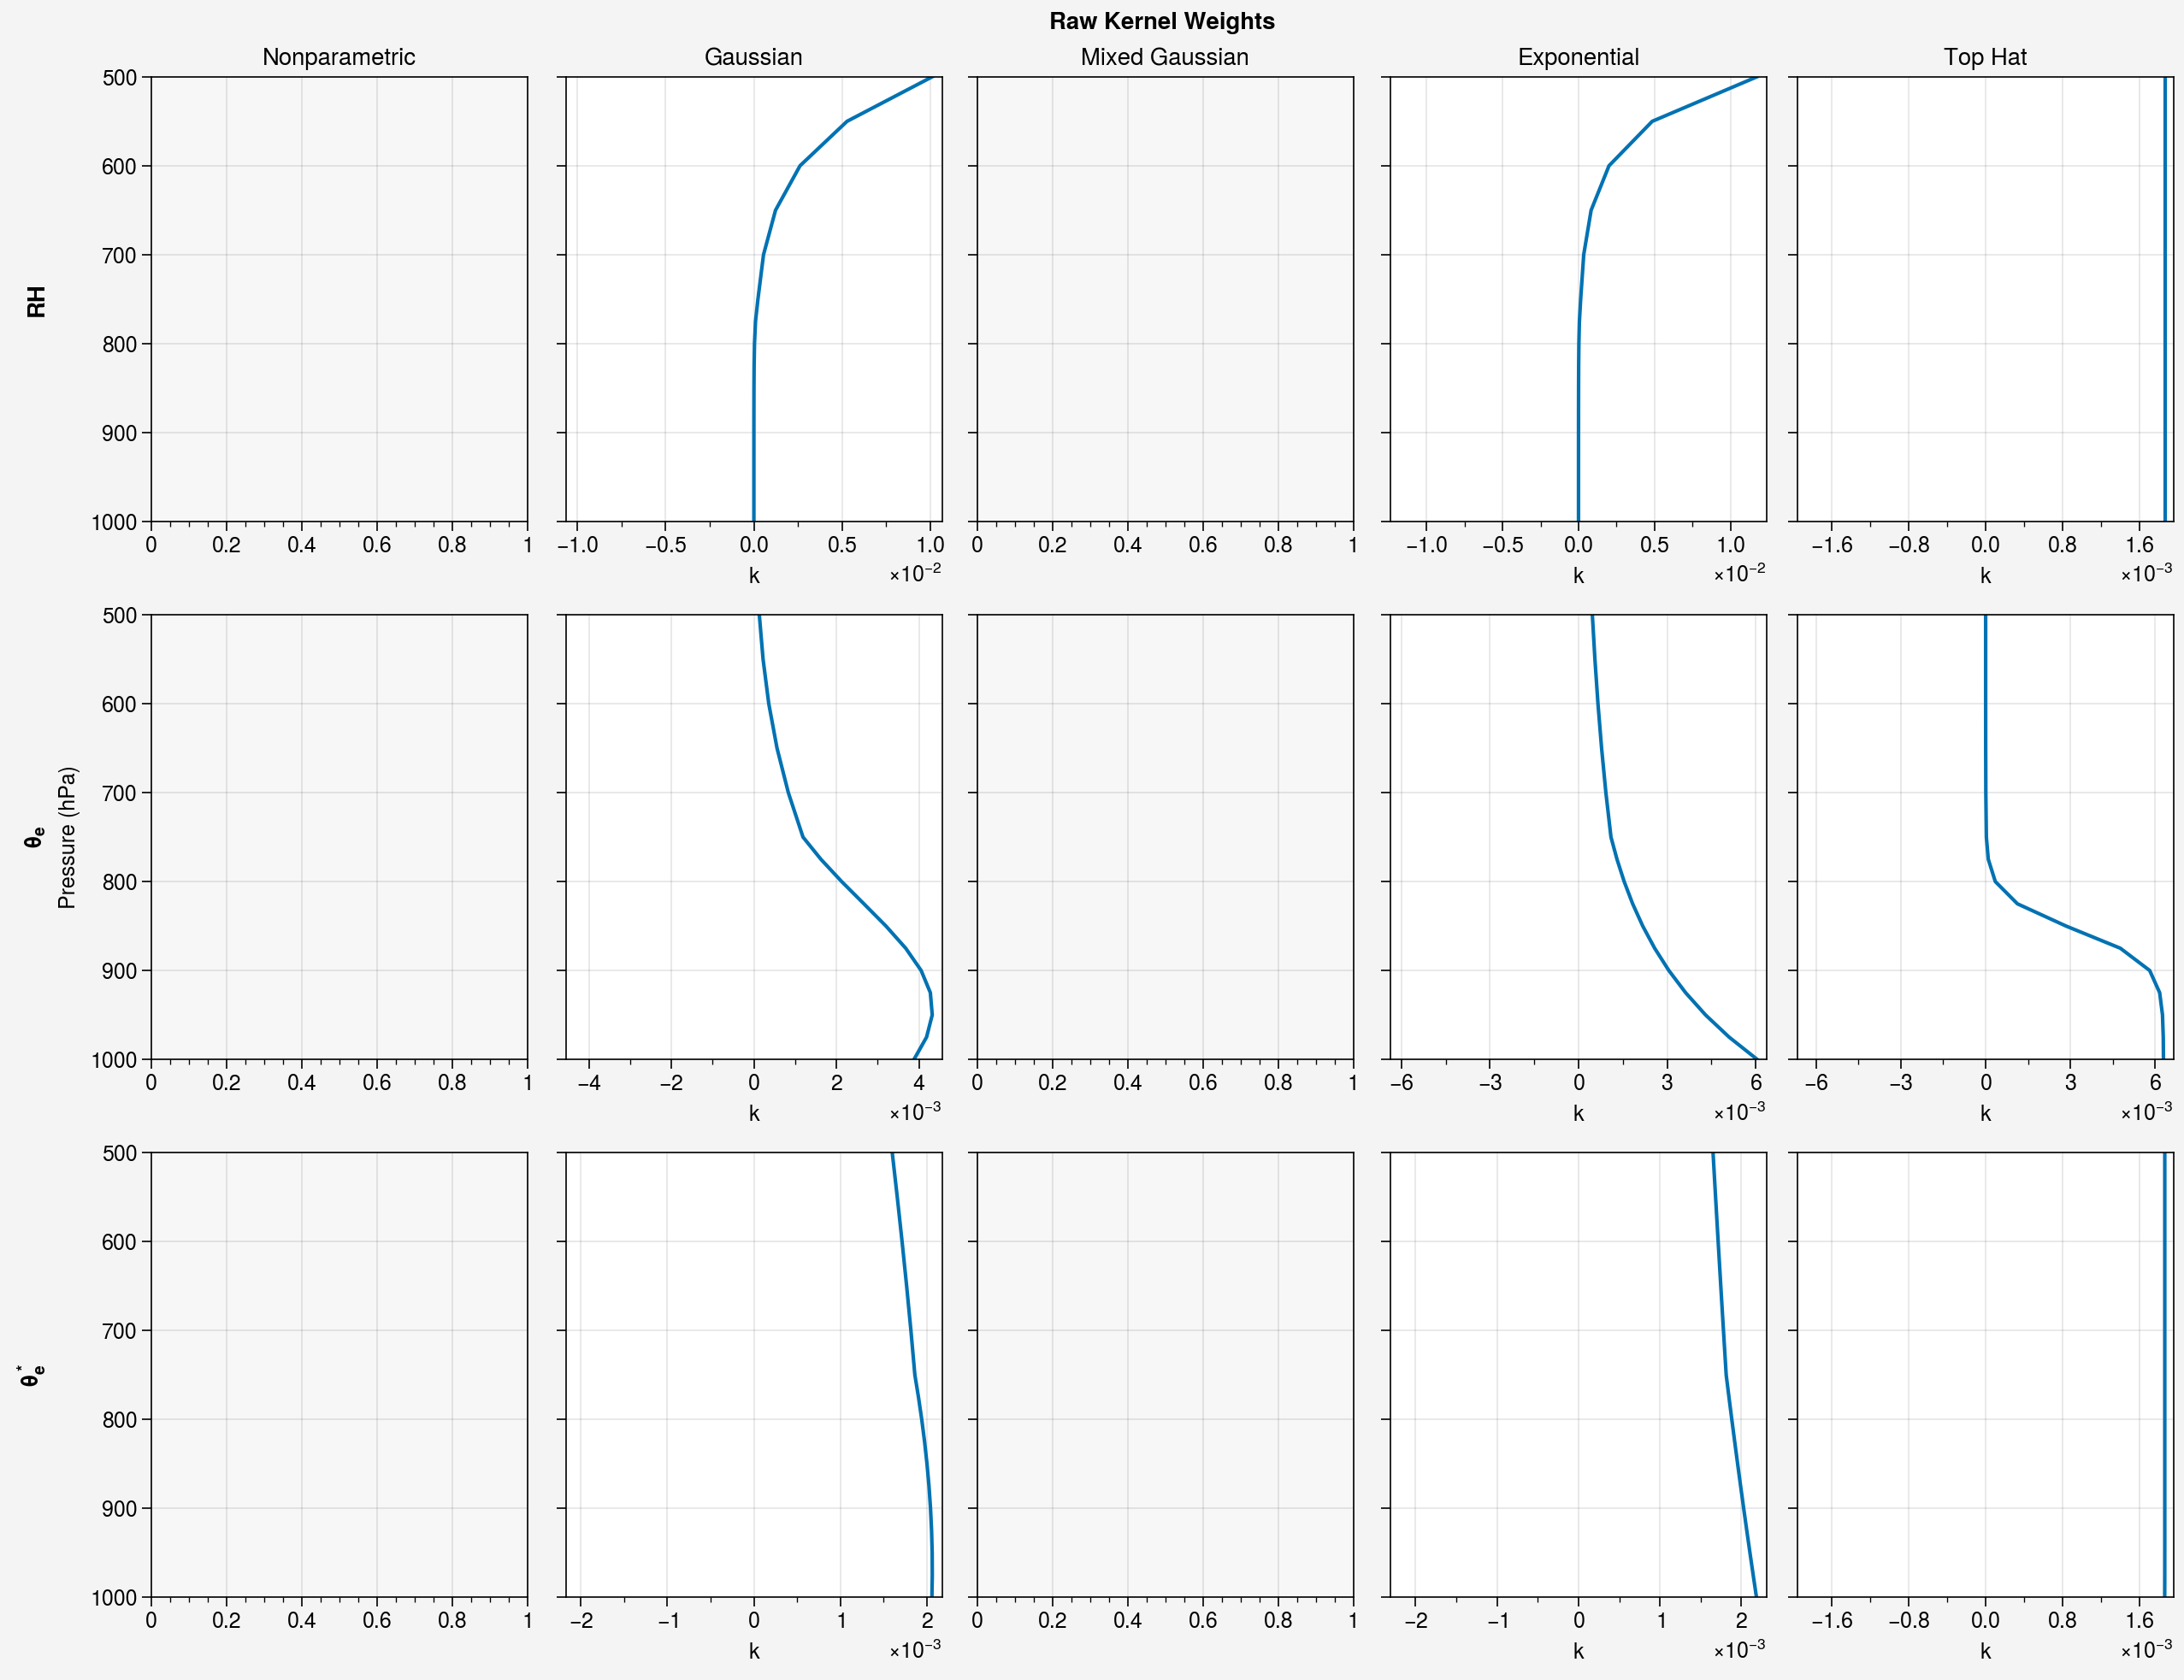

In [31]:
kernelfamilies = [
    ('nonparametric','Nonparametric'),
    ('gaussian','Gaussian'),
    ('mixgaussian','Mixed Gaussian'),
    ('exponential','Exponential'),
    ('tophat','Top Hat')
]

family_to_name = {
    fam: next((nm for nm in results.keys() if fam in nm), None)
    for fam, _ in kernelfamilies}

rowlabels = ['RH', r'$\theta_e$', r'$\theta_e^*$']
nrows, ncols = 3, len(kernelfamilies)

fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, refwidth=2.2, refheight=2.6, sharey=True, sharex=False)
axs.format(
    suptitle='Raw Kernel Weights',
    yreverse=True,
    ylabel='Pressure (hPa)',
    yminorticks='none',
    rowlabels=rowlabels)

for j, (fam, title) in enumerate(kernelfamilies):
    axs[0, j].format(title=title)
    name = family_to_name[fam]
    if name is None:
        for i in range(nrows):
            axs[i, j].format(alpha=0.35)
        continue
    entry = results[name]
    kind = entry['kind']
    for i in range(nrows):
        ax = axs[i, j]
        if kind == 'mixture':
            m1 = entry['mean1'].isel(field=i)
            m2 = entry['mean2'].isel(field=i)
            ax.plot(m1, lev, lw=1.5, label='Comp 1')
            ax.plot(m2, lev, lw=1.5, ls='--', label='Comp 2')
            maxabs = float(np.nanmax(np.abs([m1.values, m2.values])))
            if entry['std1'] is not None:
                s1 = entry['std1'].isel(field=i)
                s2 = entry['std2'].isel(field=i)
                ax.fill_betweenx(lev, m1 - s1, m1 + s1, alpha=0.2)
                ax.fill_betweenx(lev, m2 - s2, m2 + s2, alpha=0.2)
                maxabs = max(maxabs,
                             float(np.nanmax(np.abs((m1 - s1).values))),
                             float(np.nanmax(np.abs((m1 + s1).values))),
                             float(np.nanmax(np.abs((m2 - s2).values))),
                             float(np.nanmax(np.abs((m2 + s2).values))))
            if i == 0:
                ax.legend(loc='upper right', fontsize=7)
        else:
            m = entry['mean'].isel(field=i)
            ax.plot(m, lev, lw=1.5)
            maxabs = float(np.nanmax(np.abs(m.values)))
            if entry['std'] is not None:
                s = entry['std'].isel(field=i)
                ax.fill_betweenx(lev, m - s, m + s, alpha=0.25)
                maxabs = max(maxabs,
                             float(np.nanmax(np.abs((m - s).values))),
                             float(np.nanmax(np.abs((m + s).values))))
        maxabs = max(maxabs, 1e-12)
        ax.format(xlim=(-1.05 * maxabs, 1.05 * maxabs))
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
        ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

pplt.show()
fig.save('../figs/weights.png', dpi=300)